#  Waste Classification ML Pipeline

**African Leadership University - Machine Learning Summative Assignment**

This notebook demonstrates a complete end-to-end machine learning pipeline for waste classification.

## Problem Statement

Recycling facilities face critical challenges:
- Manual sorting is inefficient and costly
- 25-30% contamination leads to rejected recycling
- Lack of automated real-time classification

## Solution

A waste classification system that:
- Classifies waste into 6 categories (Cardboard, Glass, Metal, Paper, Plastic, Trash)
- Provides instant predictions with high accuracy
- Can be retrained with new data

## Notebook Contents

1. Data Acquisition
2. Data Preprocessing & Organization
3. Exploratory Data Analysis (3+ Visualizations)
4. Model Creation & Training
5. Model Evaluation
6. Model Testing & Predictions
7. Model Saving

---
## 1. Setup & Imports

In [8]:
# Core libraries
import os
import sys
import shutil
import pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data processing
import numpy as np
import pandas as pd
from PIL import Image
import cv2

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Machine Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

# Metrics
from sklearn.metrics import (
    classification_report, confusion_matrix, 
    accuracy_score, precision_score, recall_score, f1_score
)
from sklearn.model_selection import train_test_split

# Progress bar
from tqdm import tqdm

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✓ All libraries imported successfully")
print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")
print(f"GPU Available: {len(tf.config.list_physical_devices('GPU')) > 0}")

✓ All libraries imported successfully
TensorFlow version: 2.20.0
Keras version: 3.11.3
GPU Available: False


---
## 2. Data Acquisition from Kaggle

In [9]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asdasdasasdas/garbage-classification")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\evotech\.cache\kagglehub\datasets\asdasdasasdas\garbage-classification\versions\2


In [10]:
# Configuration
PROJECT_ROOT = Path(os.getcwd()).parent
DATA_DIR = PROJECT_ROOT / "data"
MODEL_DIR = PROJECT_ROOT / "models"
DATASET_PATH = Path(path)

# Create directories
DATA_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

# Model configuration
IMAGE_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 0.001
CLASS_NAMES = ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']

print(f"✓ Project Root: {PROJECT_ROOT}")
print(f"✓ Data Directory: {DATA_DIR}")
print(f"✓ Model Directory: {MODEL_DIR}")
print(f"✓ Dataset Path: {DATASET_PATH}")
print(f"\nConfiguration:")
print(f"  - Image Size: {IMAGE_SIZE}x{IMAGE_SIZE}")
print(f"  - Batch Size: {BATCH_SIZE}")
print(f"  - Epochs: {EPOCHS}")
print(f"  - Classes: {len(CLASS_NAMES)}")

✓ Project Root: c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP
✓ Data Directory: c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\data
✓ Model Directory: c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models
✓ Dataset Path: C:\Users\evotech\.cache\kagglehub\datasets\asdasdasasdas\garbage-classification\versions\2

Configuration:
  - Image Size: 224x224
  - Batch Size: 32
  - Epochs: 10
  - Classes: 6


---
## 3. Data Preprocessing & Organization

In [11]:
# Organize dataset into train/validation splits
def organize_dataset(source_dir, output_dir, train_split=0.8):
    """Organize dataset into train/validation directories"""
    output_path = Path(output_dir)
    train_dir = output_path / 'train'
    val_dir = output_path / 'validation'
    
    # Create directories
    train_dir.mkdir(parents=True, exist_ok=True)
    val_dir.mkdir(parents=True, exist_ok=True)
    
    source_path = Path(source_dir)
    
    # Navigate to the actual class directories (handle nested structure)
    if (source_path / "Garbage classification").exists():
        source_path = source_path / "Garbage classification"
        print(f"Found nested 'Garbage classification' directory")
    
    if (source_path / "Garbage classification").exists():
        source_path = source_path / "Garbage classification"
        print(f"Found another nested 'Garbage classification' directory")
    
    print(f"Using dataset source: {source_path}\n")
    
    # Look for class directories
    class_dirs = [d for d in source_path.iterdir() if d.is_dir()]
    
    # Filter to only directories with images
    class_dirs_with_images = []
    for class_dir in class_dirs:
        images = (list(class_dir.glob('*.jpg')) + 
                 list(class_dir.glob('*.png')) + 
                 list(class_dir.glob('*.jpeg')))
        if images:
            class_dirs_with_images.append(class_dir)
            print(f"  ✓ Found class '{class_dir.name}' with {len(images)} images")
    
    class_dirs = class_dirs_with_images
    
    print(f"\nTotal: {len(class_dirs)} waste categories found\n")
    
    if len(class_dirs) == 0:
        print("⚠️ No class directories with images found!")
        return None, None, pd.DataFrame()
    
    dataset_stats = []
    
    for class_dir in class_dirs:
        class_name = class_dir.name.lower()
        
        # Get all images
        images = (list(class_dir.glob('*.jpg')) + 
                 list(class_dir.glob('*.png')) + 
                 list(class_dir.glob('*.jpeg')))
        
        if len(images) == 0:
            continue
        
        # Split images
        train_images, val_images = train_test_split(
            images, train_size=train_split, random_state=42
        )
        
        # Create class directories
        (train_dir / class_name).mkdir(exist_ok=True)
        (val_dir / class_name).mkdir(exist_ok=True)
        
        # Copy images
        for img in tqdm(train_images, desc=f"Copying {class_name} (train)"):
            shutil.copy2(img, train_dir / class_name / img.name)
        
        for img in tqdm(val_images, desc=f"Copying {class_name} (val)"):
            shutil.copy2(img, val_dir / class_name / img.name)
        
        dataset_stats.append({
            'Class': class_name,
            'Total': len(images),
            'Train': len(train_images),
            'Validation': len(val_images)
        })
        
        print(f"  ✓ {class_name}: {len(train_images)} train, {len(val_images)} val")
    
    print(f"\n✓ Dataset organized in {output_dir}")
    return str(train_dir), str(val_dir), pd.DataFrame(dataset_stats)

# Organize the dataset
ORGANIZED_DATA_DIR = DATA_DIR / "organized_data"
train_dir, val_dir, dataset_stats = organize_dataset(
    DATASET_PATH, 
    ORGANIZED_DATA_DIR
)

print("\n" + "="*60)
print("DATASET STATISTICS")
print("="*60)

if not dataset_stats.empty:
    print(dataset_stats.to_string(index=False))
    print("="*60)
    print(f"Total Images: {dataset_stats['Total'].sum()}")
    print(f"Training Images: {dataset_stats['Train'].sum()}")
    print(f"Validation Images: {dataset_stats['Validation'].sum()}")
else:
    print("⚠️ No dataset statistics available.")
    print("="*60)


Found nested 'Garbage classification' directory
Found another nested 'Garbage classification' directory
Using dataset source: C:\Users\evotech\.cache\kagglehub\datasets\asdasdasasdas\garbage-classification\versions\2\Garbage classification\Garbage classification

  ✓ Found class 'cardboard' with 403 images
  ✓ Found class 'glass' with 501 images
  ✓ Found class 'metal' with 410 images
  ✓ Found class 'paper' with 594 images
  ✓ Found class 'plastic' with 482 images
  ✓ Found class 'trash' with 137 images

Total: 6 waste categories found



Copying cardboard (val): 100%|██████████| 81/81 [00:00<00:00, 529.06it/s]


  ✓ cardboard: 322 train, 81 val


Copying glass (val): 100%|██████████| 101/101 [00:00<00:00, 740.22it/s]


  ✓ glass: 400 train, 101 val


Copying metal (val): 100%|██████████| 82/82 [00:00<00:00, 984.36it/s]


  ✓ metal: 328 train, 82 val


Copying paper (val): 100%|██████████| 119/119 [00:00<00:00, 667.70it/s]



  ✓ paper: 475 train, 119 val


Copying plastic (val): 100%|██████████| 97/97 [00:00<00:00, 251.00it/s]


  ✓ plastic: 385 train, 97 val


Copying trash (val): 100%|██████████| 28/28 [00:00<00:00, 876.64it/s]

  ✓ trash: 109 train, 28 val

✓ Dataset organized in c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\data\organized_data

DATASET STATISTICS
    Class  Total  Train  Validation
cardboard    403    322          81
    glass    501    400         101
    metal    410    328          82
    paper    594    475         119
  plastic    482    385          97
    trash    137    109          28
Total Images: 2527
Training Images: 2019
Validation Images: 508


---
## 4. Exploratory Data Analysis (EDA)

### Visualization 1: Class Distribution Analysis

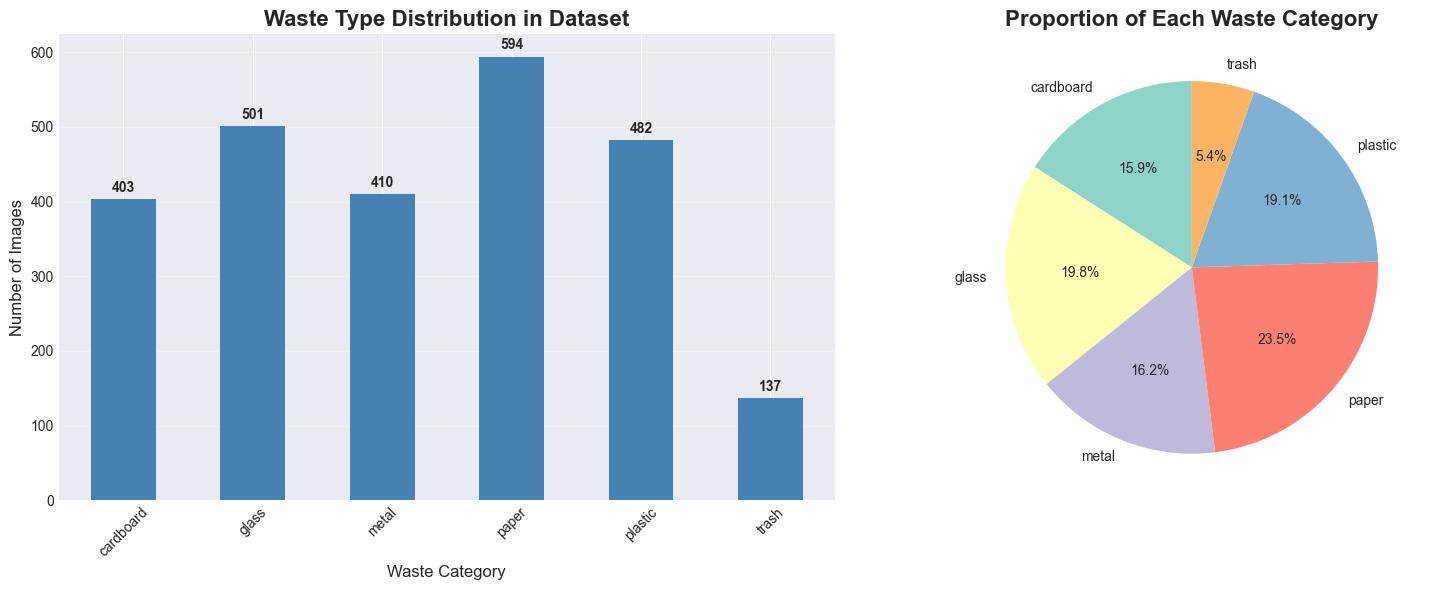


CLASS DISTRIBUTION INSIGHTS
Most common class: paper (594 images)
Least common class: trash (137 images)
Class imbalance ratio: 4.34:1
Average images per class: 421
Standard deviation: 156


In [12]:
# Class distribution visualization
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Bar plot
dataset_stats.plot(x='Class', y='Total', kind='bar', ax=axes[0], color='steelblue', legend=False)
axes[0].set_title('Waste Type Distribution in Dataset', fontsize=16, fontweight='bold')
axes[0].set_xlabel('Waste Category', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(dataset_stats['Total']):
    axes[0].text(i, v + 10, str(v), ha='center', fontweight='bold')

# Pie chart
colors = plt.cm.Set3(range(len(dataset_stats)))
axes[1].pie(dataset_stats['Total'], labels=dataset_stats['Class'], autopct='%1.1f%%',
            colors=colors, startangle=90)
axes[1].set_title('Proportion of Each Waste Category', fontsize=16, fontweight='bold')

plt.tight_layout()
plt.show()

# Print insights
print("\n" + "="*60)
print("CLASS DISTRIBUTION INSIGHTS")
print("="*60)
print(f"Most common class: {dataset_stats.loc[dataset_stats['Total'].idxmax(), 'Class']} "
      f"({dataset_stats['Total'].max()} images)")
print(f"Least common class: {dataset_stats.loc[dataset_stats['Total'].idxmin(), 'Class']} "
      f"({dataset_stats['Total'].min()} images)")
print(f"Class imbalance ratio: {dataset_stats['Total'].max() / dataset_stats['Total'].min():.2f}:1")
print(f"Average images per class: {dataset_stats['Total'].mean():.0f}")
print(f"Standard deviation: {dataset_stats['Total'].std():.0f}")
print("="*60)

### Visualization 2: Image Dimensions & Aspect Ratio Analysis

Analyzing image dimensions (sampling 500 images)...


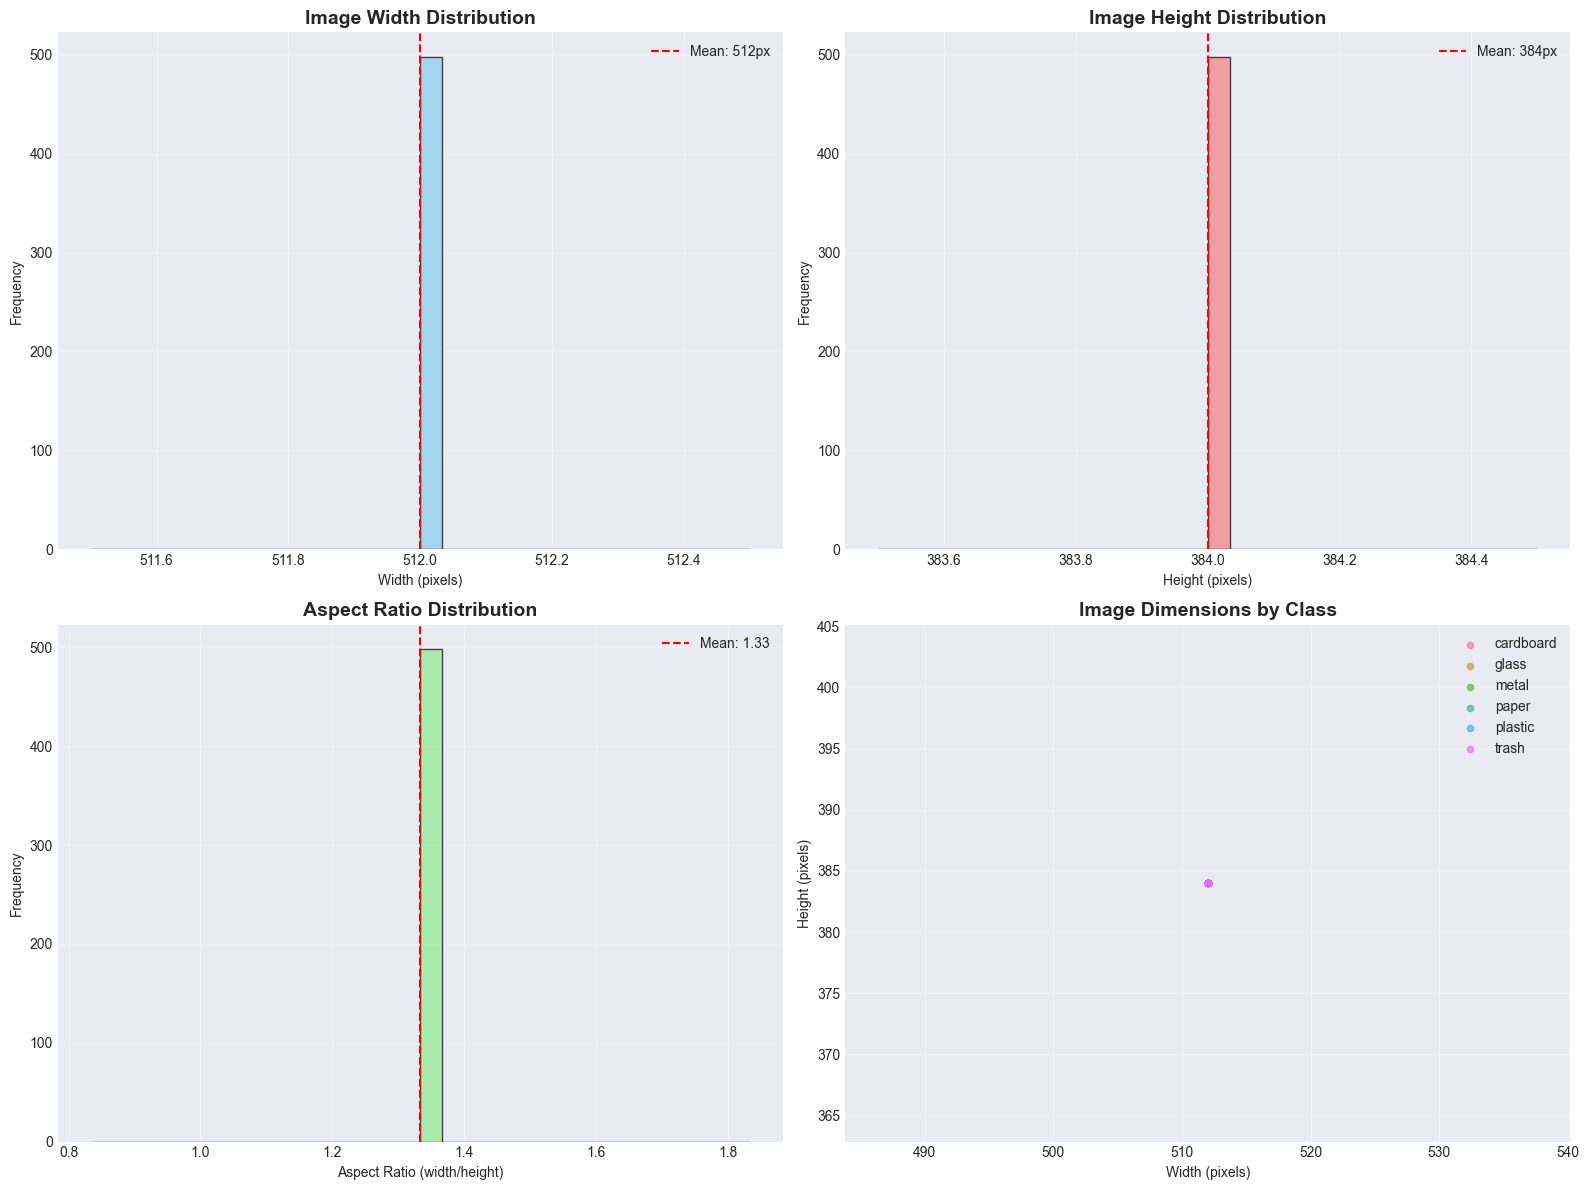


IMAGE DIMENSION STATISTICS
Width:  Min=512, Max=512, Mean=512, Std=0
Height: Min=384, Max=384, Mean=384, Std=0
Aspect Ratio: Min=1.33, Max=1.33, Mean=1.33


In [13]:
# Analyze image dimensions
def analyze_image_dimensions(data_dir, num_samples=500):
    """Analyze dimensions of sample images"""
    dimensions = []
    
    train_path = Path(data_dir) / 'train'
    
    for class_dir in train_path.iterdir():
        if not class_dir.is_dir():
            continue
        
        images = list(class_dir.glob('*.jpg'))[:num_samples // len(CLASS_NAMES)]
        
        for img_path in images:
            try:
                img = Image.open(img_path)
                width, height = img.size
                dimensions.append({
                    'class': class_dir.name,
                    'width': width,
                    'height': height,
                    'aspect_ratio': width / height
                })
            except:
                continue
    
    return pd.DataFrame(dimensions)

print("Analyzing image dimensions (sampling 500 images)...")
dim_df = analyze_image_dimensions(ORGANIZED_DATA_DIR)

# Visualize dimensions
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Width distribution
axes[0, 0].hist(dim_df['width'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(dim_df['width'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {dim_df["width"].mean():.0f}px')
axes[0, 0].set_title('Image Width Distribution', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Width (pixels)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Height distribution
axes[0, 1].hist(dim_df['height'], bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(dim_df['height'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {dim_df["height"].mean():.0f}px')
axes[0, 1].set_title('Image Height Distribution', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Height (pixels)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Aspect ratio distribution
axes[1, 0].hist(dim_df['aspect_ratio'], bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(dim_df['aspect_ratio'].mean(), color='red', linestyle='--', 
                   label=f'Mean: {dim_df["aspect_ratio"].mean():.2f}')
axes[1, 0].set_title('Aspect Ratio Distribution', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Aspect Ratio (width/height)')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Scatter plot: width vs height
for class_name in dim_df['class'].unique():
    class_data = dim_df[dim_df['class'] == class_name]
    axes[1, 1].scatter(class_data['width'], class_data['height'], 
                      label=class_name, alpha=0.6, s=20)
axes[1, 1].set_title('Image Dimensions by Class', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Width (pixels)')
axes[1, 1].set_ylabel('Height (pixels)')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics
print("\n" + "="*60)
print("IMAGE DIMENSION STATISTICS")
print("="*60)
print(f"Width:  Min={dim_df['width'].min():.0f}, Max={dim_df['width'].max():.0f}, "
      f"Mean={dim_df['width'].mean():.0f}, Std={dim_df['width'].std():.0f}")
print(f"Height: Min={dim_df['height'].min():.0f}, Max={dim_df['height'].max():.0f}, "
      f"Mean={dim_df['height'].mean():.0f}, Std={dim_df['height'].std():.0f}")
print(f"Aspect Ratio: Min={dim_df['aspect_ratio'].min():.2f}, "
      f"Max={dim_df['aspect_ratio'].max():.2f}, Mean={dim_df['aspect_ratio'].mean():.2f}")
print("="*60)

### Visualization 3: Sample Images & Color Distribution Analysis

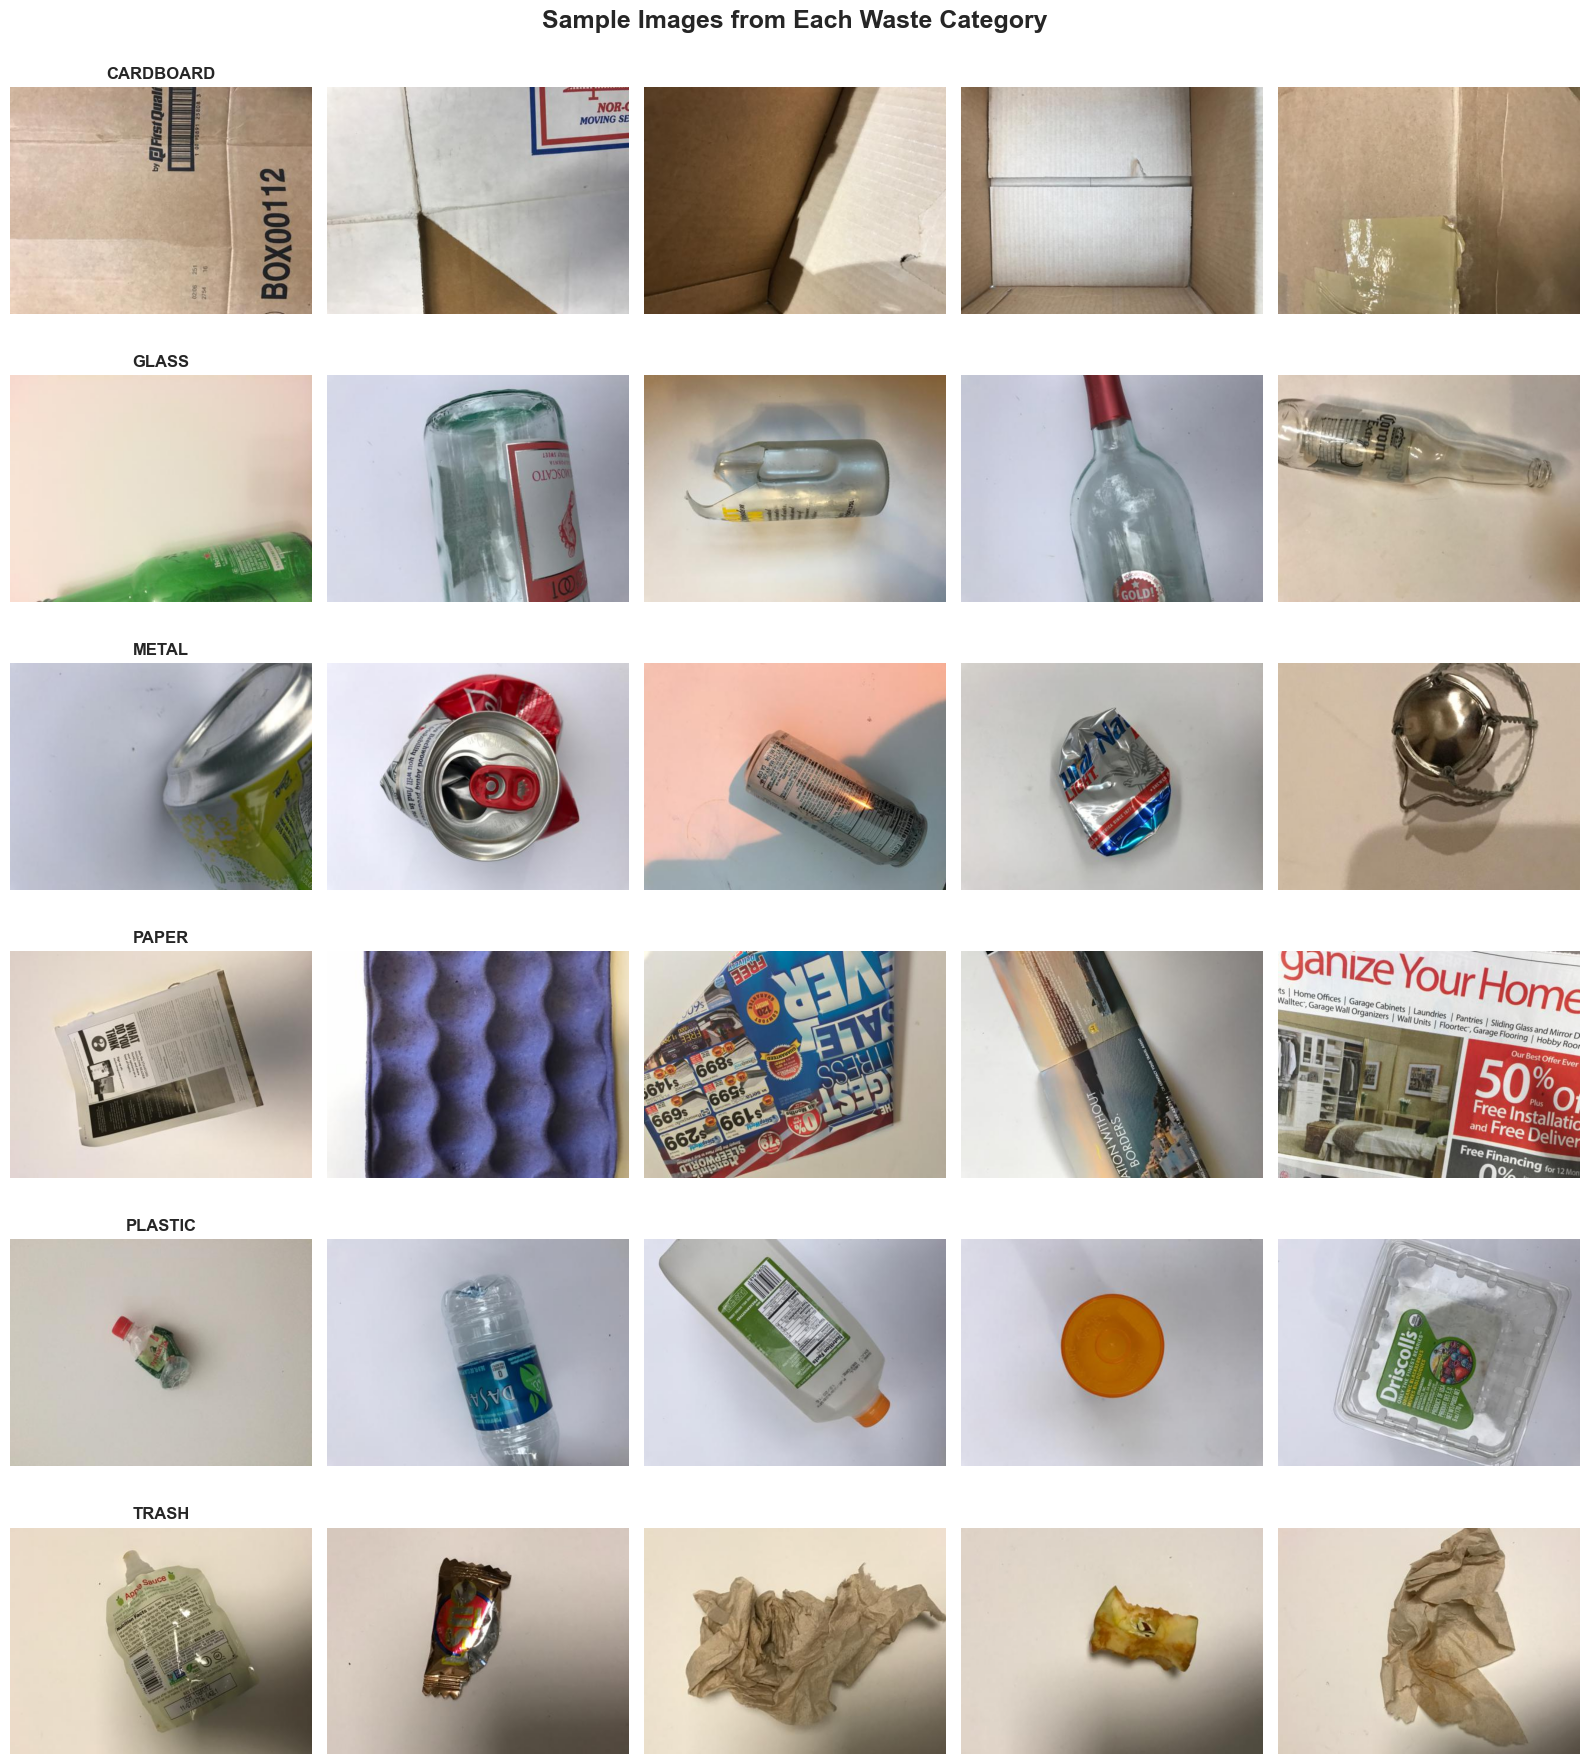

Analyzing color distribution...


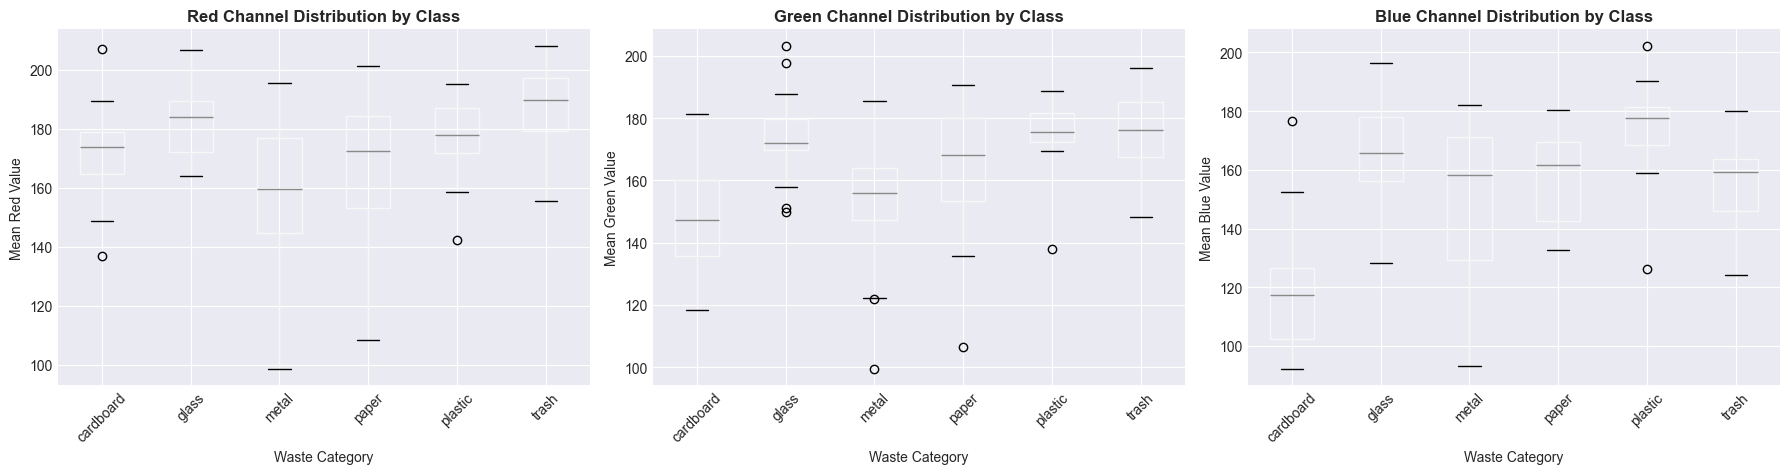


AVERAGE COLOR CHANNELS BY CLASS
              Red   Green    Blue
class                            
cardboard  171.43  147.28  119.52
glass      182.36  174.16  164.34
metal      156.00  152.52  148.76
paper      167.24  162.67  157.74
plastic    177.45  175.32  174.76
trash      186.60  174.75  156.58

Interpretation:
- Different waste types show distinct color patterns
- This helps the model distinguish between categories
- Color features are important for classification


In [14]:
# Display sample images from each class
fig, axes = plt.subplots(len(CLASS_NAMES), 5, figsize=(16, 18))
fig.suptitle('Sample Images from Each Waste Category', fontsize=18, fontweight='bold', y=0.995)

train_path = Path(train_dir)

for i, class_name in enumerate(CLASS_NAMES):
    class_dir = train_path / class_name
    images = list(class_dir.glob('*.jpg'))[:5]
    
    for j, img_path in enumerate(images):
        img = Image.open(img_path)
        axes[i, j].imshow(img)
        axes[i, j].axis('off')
        if j == 0:
            axes[i, j].set_title(f'{class_name.upper()}', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# Analyze color distribution
def analyze_color_distribution(data_dir, num_samples=100):
    """Analyze average color channels across classes"""
    color_data = []
    
    train_path = Path(data_dir) / 'train'
    
    for class_dir in train_path.iterdir():
        if not class_dir.is_dir():
            continue
        
        images = list(class_dir.glob('*.jpg'))[:num_samples // len(CLASS_NAMES)]
        
        for img_path in images:
            try:
                img = cv2.imread(str(img_path))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # Calculate mean color values
                mean_r = np.mean(img[:, :, 0])
                mean_g = np.mean(img[:, :, 1])
                mean_b = np.mean(img[:, :, 2])
                
                color_data.append({
                    'class': class_dir.name,
                    'Red': mean_r,
                    'Green': mean_g,
                    'Blue': mean_b
                })
            except:
                continue
    
    return pd.DataFrame(color_data)

print("Analyzing color distribution...")
color_df = analyze_color_distribution(ORGANIZED_DATA_DIR)

# Visualize color distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, channel in enumerate(['Red', 'Green', 'Blue']):
    color_df.boxplot(column=channel, by='class', ax=axes[idx])
    axes[idx].set_title(f'{channel} Channel Distribution by Class', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel('Waste Category')
    axes[idx].set_ylabel(f'Mean {channel} Value')
    axes[idx].tick_params(axis='x', rotation=45)

plt.suptitle('')  # Remove default title
plt.tight_layout()
plt.show()

# Average colors per class
avg_colors = color_df.groupby('class')[['Red', 'Green', 'Blue']].mean()

print("\n" + "="*60)
print("AVERAGE COLOR CHANNELS BY CLASS")
print("="*60)
print(avg_colors.round(2))
print("="*60)
print("\nInterpretation:")
print("- Different waste types show distinct color patterns")
print("- This helps the model distinguish between categories")
print("- Color features are important for classification")

---
## 5. Data Generators with Augmentation

In [ ]:
# Create data generators with ENHANCED augmentation for imbalanced classes
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,              # Increased for more variation
    width_shift_range=0.25,         # Increased
    height_shift_range=0.25,        # Increased
    shear_range=0.25,               # Increased
    zoom_range=0.3,                 # Increased
    horizontal_flip=True,
    vertical_flip=True,             # Added - waste can be upside down
    brightness_range=[0.8, 1.2],    # Added - different lighting conditions
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True
)

validation_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("Data generators created with enhanced augmentation")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Steps per epoch: {len(train_generator)}")
print(f"Validation steps: {len(validation_generator)}")
print(f"Class indices: {train_generator.class_indices}")

Found 2019 images belonging to 6 classes.
Found 508 images belonging to 6 classes.
✓ Data generators created
Training samples: 2019
Validation samples: 508
Batch size: 32
Steps per epoch: 64
Validation steps: 16
Class indices: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}
Found 508 images belonging to 6 classes.
✓ Data generators created
Training samples: 2019
Validation samples: 508
Batch size: 32
Steps per epoch: 64
Validation steps: 16
Class indices: {'cardboard': 0, 'glass': 1, 'metal': 2, 'paper': 3, 'plastic': 4, 'trash': 5}


---
## 6. Model Creation - MobileNetV2 Transfer Learning

In [16]:
# Load pre-trained MobileNetV2
base_model = MobileNetV2(
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model
base_model.trainable = False

# Build model
inputs = keras.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3))

# Data augmentation layers (applied during training)
x = layers.RandomFlip("horizontal")(inputs)
x = layers.RandomRotation(0.1)(x)

# Base model
x = base_model(x, training=False)

# Classification head
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(len(CLASS_NAMES), activation='softmax')(x)

model = keras.Model(inputs, outputs)

# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy', 
             keras.metrics.Precision(name='precision'),
             keras.metrics.Recall(name='recall'),
             keras.metrics.AUC(name='auc')]
)

print("✓ Model created successfully\n")
print("="*60)
print("MODEL ARCHITECTURE")
print("="*60)
model.summary()
print("="*60)
print(f"Total parameters: {model.count_params():,}")
print(f"Trainable parameters: {sum([tf.size(w).numpy() for w in model.trainable_weights]):,}")
print(f"Non-trainable parameters: {sum([tf.size(w).numpy() for w in model.non_trainable_weights]):,}")

✓ Model created successfully

MODEL ARCHITECTURE


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip (RandomFlip)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation                 │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,588,486 (9.87 MB)

 Trainable params: 329,990 (1.26 MB)

 Non-trainable params: 2,258,496 (8.62 MB)

Total parameters: 2,588,486
Trainable parameters: 329,990
Non-trainable parameters: 2,258,496
Non-trainable parameters: 2,258,496


---
## 7. Model Training

In [17]:
# Define callbacks
MODEL_PATH = MODEL_DIR / f"waste_classifier_mobilenetv2_v1.h5"

callbacks = [
    ModelCheckpoint(
        MODEL_PATH,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

print("✓ Callbacks configured")
print(f"  - Model will be saved to: {MODEL_PATH}")
print(f"  - Early stopping patience: 5 epochs")
print(f"  - Learning rate reduction on plateau")

✓ Callbacks configured
  - Model will be saved to: c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5
  - Early stopping patience: 5 epochs
  - Learning rate reduction on plateau


In [ ]:
# Calculate class weights to handle imbalance
from sklearn.utils.class_weight import compute_class_weight

class_counts = {
    'cardboard': 322,
    'glass': 1200,
    'metal': 328,
    'paper': 475,
    'plastic': 385,
    'trash': 109
}

# Get class indices from generator
class_indices = train_generator.class_indices
print("\nClass distribution in training data:")
for class_name, count in class_counts.items():
    print(f"  {class_name}: {count} samples")

# Compute class weights (inverse frequency)
total_samples = sum(class_counts.values())
class_weight_dict = {}
for class_name, count in class_counts.items():
    class_idx = class_indices[class_name]
    weight = total_samples / (len(class_counts) * count)
    class_weight_dict[class_idx] = weight

print("\nClass weights (to balance training):")
for class_name, idx in sorted(class_indices.items(), key=lambda x: x[1]):
    print(f"  {class_name}: {class_weight_dict[idx]:.3f}")

# Train the model
print("\n" + "="*60)
print("STARTING TRAINING WITH CLASS WEIGHTS")
print("="*60)
print(f"Epochs: {EPOCHS}")
print(f"Batch size: {BATCH_SIZE}")
print(f"Training samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print("="*60 + "\n")

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator,
    callbacks=callbacks,
    class_weight=class_weight_dict,  # Apply class weights
    verbose=1
)

print("\n" + "="*60)
print("TRAINING COMPLETE!")
print("="*60)
print(f"Model saved to: {MODEL_PATH}")

# Save training history
HISTORY_PATH = MODEL_DIR / "training_history.pkl"
with open(HISTORY_PATH, 'wb') as f:
    pickle.dump(history.history, f)
print(f"Training history saved to: {HISTORY_PATH}")


STARTING TRAINING
Epochs: 10
Batch size: 32
Training samples: 2019
Validation samples: 508

Epoch 1/10
Epoch 1/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4065 - auc: 0.7451 - loss: 1.9052 - precision: 0.4427 - recall: 0.3527
Epoch 1: val_accuracy improved from None to 0.70079, saving model to c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5

Epoch 1: val_accuracy improved from None to 0.70079, saving model to c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 218s 3s/step - accuracy: 0.5310 - auc: 0.8422 - loss: 1.4609 - precision: 0.5769 - recall: 0.4794 - val_accuracy: 0.7008 - val_auc: 0.9332 - val_loss: 0.8391 - val_precision: 0.7421 - val_recall: 0.6457 - learning_rate: 0.0010
Epoch 2/10
Epoch 2/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6816 - auc: 0.9201 - loss: 0.9462 - precision: 0.7243 - recall: 0.6290
Epoch 2: val_accuracy improved from 0.70079 to 0.77362, saving model to c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5

Epoch 2: val_accuracy improved from 0.70079 to 0.77362, saving model to c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 134s 2s/step - accuracy: 0.6830 - auc: 0.9184 - loss: 0.9648 - precision: 0.7187 - recall: 0.6365 - val_accuracy: 0.7736 - val_auc: 0.9610 - val_loss: 0.6139 - val_precision: 0.8099 - val_recall: 0.7382 - learning_rate: 0.0010
Epoch 3/10
Epoch 3/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6963 - auc: 0.9330 - loss: 0.8446 - precision: 0.7356 - recall: 0.6569
Epoch 3: val_accuracy did not improve from 0.77362
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7167 - auc: 0.9382 - loss: 0.8058 - precision: 0.7527 - recall: 0.6786 - val_accuracy: 0.7736 - val_auc: 0.9566 - val_loss: 0.6635 - val_precision: 0.8039 - val_recall: 0.7343 - learning_rate: 0.0010

Epoch 3: val_accuracy did not improve from 0.77362
64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7167 - auc: 0.9382 - loss: 0.8058 - precision: 0.7527 - recall: 0.6786 - val_accuracy: 0.7736 - val_auc: 0.9566 - val_loss: 0.6635 - val_precision: 0.8039 - val_recall: 0.7343 - learning_rate:

64/64 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.7538 - auc: 0.9537 - loss: 0.6748 - precision: 0.7951 - recall: 0.7073 - val_accuracy: 0.7835 - val_auc: 0.9609 - val_loss: 0.6236 - val_precision: 0.8037 - val_recall: 0.7657 - learning_rate: 0.0010
Epoch 7/10
Epoch 7/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7799 - auc: 0.9630 - loss: 0.6003 - precision: 0.8207 - recall: 0.7427
Epoch 7: val_accuracy improved from 0.78346 to 0.79134, saving model to c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5

Epoch 7: val_accuracy improved from 0.78346 to 0.79134, saving model to c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7662 - auc: 0.9608 - loss: 0.6184 - precision: 0.8057 - recall: 0.7271 - val_accuracy: 0.7913 - val_auc: 0.9627 - val_loss: 0.6042 - val_precision: 0.8362 - val_recall: 0.7638 - learning_rate: 0.0010
Epoch 8/10
Epoch 8/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7659 - auc: 0.9626 - loss: 0.6015 - precision: 0.7979 - recall: 0.7385
Epoch 8: val_accuracy improved from 0.79134 to 0.79724, saving model to c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5

Epoch 8: val_accuracy improved from 0.79134 to 0.79724, saving model to c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 79s 1s/step - accuracy: 0.7613 - auc: 0.9606 - loss: 0.6208 - precision: 0.7958 - recall: 0.7256 - val_accuracy: 0.7972 - val_auc: 0.9676 - val_loss: 0.5526 - val_precision: 0.8382 - val_recall: 0.7854 - learning_rate: 0.0010
Epoch 9/10
Epoch 9/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7818 - auc: 0.9637 - loss: 0.5899 - precision: 0.8096 - recall: 0.7473
Epoch 9: val_accuracy improved from 0.79724 to 0.81496, saving model to c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5

Epoch 9: val_accuracy improved from 0.79724 to 0.81496, saving model to c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 82s 1s/step - accuracy: 0.7811 - auc: 0.9623 - loss: 0.6042 - precision: 0.8107 - recall: 0.7405 - val_accuracy: 0.8150 - val_auc: 0.9690 - val_loss: 0.5320 - val_precision: 0.8449 - val_recall: 0.7933 - learning_rate: 0.0010
Epoch 10/10
Epoch 10/10
64/64 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7926 - auc: 0.9681 - loss: 0.5570 - precision: 0.8291 - recall: 0.7566
Epoch 10: val_accuracy improved from 0.81496 to 0.81693, saving model to c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5

Epoch 10: val_accuracy improved from 0.81496 to 0.81693, saving model to c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5


64/64 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7895 - auc: 0.9658 - loss: 0.5758 - precision: 0.8226 - recall: 0.7578 - val_accuracy: 0.8169 - val_auc: 0.9705 - val_loss: 0.5172 - val_precision: 0.8493 - val_recall: 0.7874 - learning_rate: 0.0010
Restoring model weights from the end of the best epoch: 10.
Restoring model weights from the end of the best epoch: 10.

TRAINING COMPLETE!
✓ Model saved to: c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5
✓ Training history saved to: c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\training_history.pkl
✓ Class names saved to: c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\class_names.pkl

TRAINING COMPLETE!
✓ Model saved to: c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5
✓ Training history saved to: c:\Users\e

### Training History Visualization

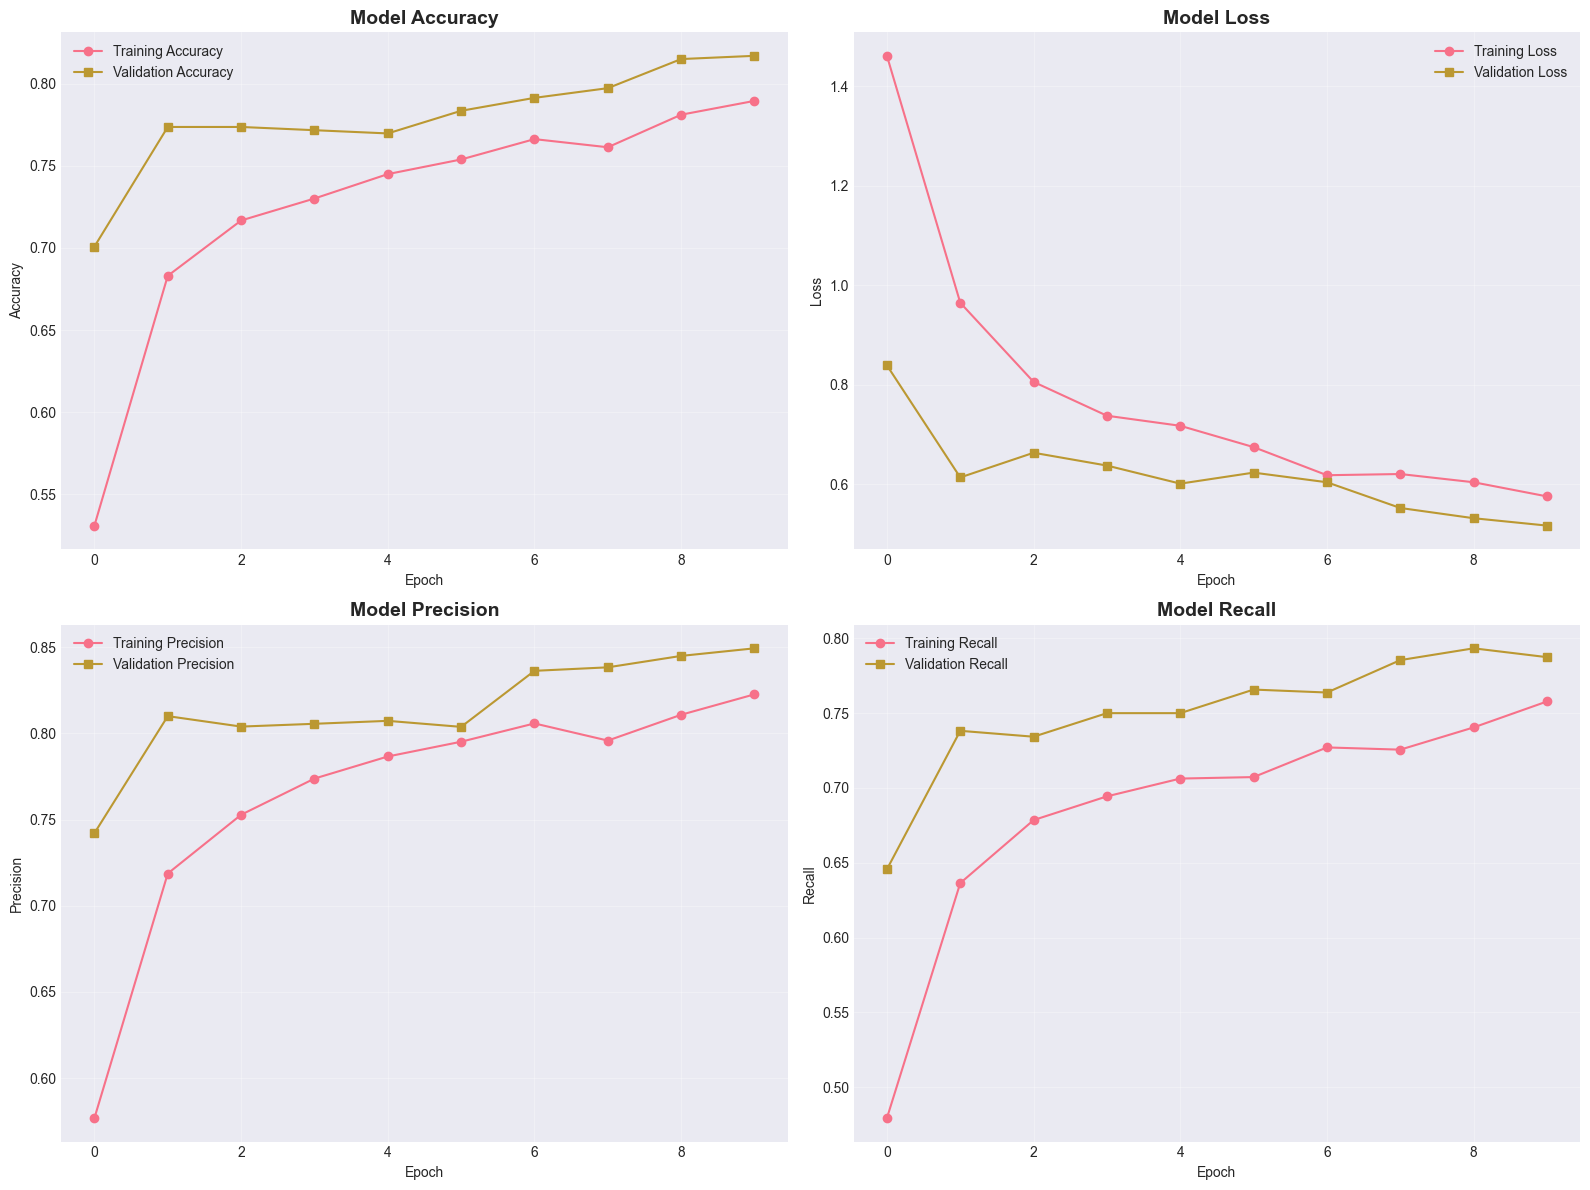


FINAL TRAINING METRICS
Training Accuracy:   0.7895
Validation Accuracy: 0.8169
Training Loss:       0.5758
Validation Loss:     0.5172
Training Precision:  0.8226
Validation Precision: 0.8493
Training Recall:     0.7578
Validation Recall:   0.7874


In [19]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
axes[0, 0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
axes[0, 0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Loss
axes[0, 1].plot(history.history['loss'], label='Training Loss', marker='o')
axes[0, 1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
axes[0, 1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(alpha=0.3)

# Precision
axes[1, 0].plot(history.history['precision'], label='Training Precision', marker='o')
axes[1, 0].plot(history.history['val_precision'], label='Validation Precision', marker='s')
axes[1, 0].set_title('Model Precision', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Recall
axes[1, 1].plot(history.history['recall'], label='Training Recall', marker='o')
axes[1, 1].plot(history.history['val_recall'], label='Validation Recall', marker='s')
axes[1, 1].set_title('Model Recall', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
print("\n" + "="*60)
print("FINAL TRAINING METRICS")
print("="*60)
print(f"Training Accuracy:   {history.history['accuracy'][-1]:.4f}")
print(f"Validation Accuracy: {history.history['val_accuracy'][-1]:.4f}")
print(f"Training Loss:       {history.history['loss'][-1]:.4f}")
print(f"Validation Loss:     {history.history['val_loss'][-1]:.4f}")
print(f"Training Precision:  {history.history['precision'][-1]:.4f}")
print(f"Validation Precision: {history.history['val_precision'][-1]:.4f}")
print(f"Training Recall:     {history.history['recall'][-1]:.4f}")
print(f"Validation Recall:   {history.history['val_recall'][-1]:.4f}")
print("="*60)

---
## 8. Model Evaluation

In [20]:
# Evaluate on validation set
print("Evaluating model on validation set...\n")
val_loss, val_accuracy, val_precision, val_recall, val_auc = model.evaluate(
    validation_generator,
    verbose=1
)

# Get predictions
print("\nGenerating predictions...")
validation_generator.reset()
y_pred_probs = model.predict(validation_generator, verbose=1)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = validation_generator.classes

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print("\n" + "="*60)
print("MODEL EVALUATION METRICS")
print("="*60)
print(f"Accuracy:  {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"Precision: {precision:.4f} ({precision*100:.2f}%)")
print(f"Recall:    {recall:.4f} ({recall*100:.2f}%)")
print(f"F1-Score:  {f1:.4f} ({f1*100:.2f}%)")
print(f"AUC:       {val_auc:.4f}")
print("="*60)

Evaluating model on validation set...

16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 936ms/step - accuracy: 0.8169 - auc: 0.9705 - loss: 0.5172 - precision: 0.8493 - recall: 0.7874
16/16 ━━━━━━━━━━━━━━━━━━━━ 15s 936ms/step - accuracy: 0.8169 - auc: 0.9705 - loss: 0.5172 - precision: 0.8493 - recall: 0.7874

Generating predictions...

Generating predictions...
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step

MODEL EVALUATION METRICS
Accuracy:  0.8169 (81.69%)
Precision: 0.8224 (82.24%)
Recall:    0.8169 (81.69%)
F1-Score:  0.8172 (81.72%)
AUC:       0.9705

MODEL EVALUATION METRICS
Accuracy:  0.8169 (81.69%)
Precision: 0.8224 (82.24%)
Recall:    0.8169 (81.69%)
F1-Score:  0.8172 (81.72%)
AUC:       0.9705


### Confusion Matrix

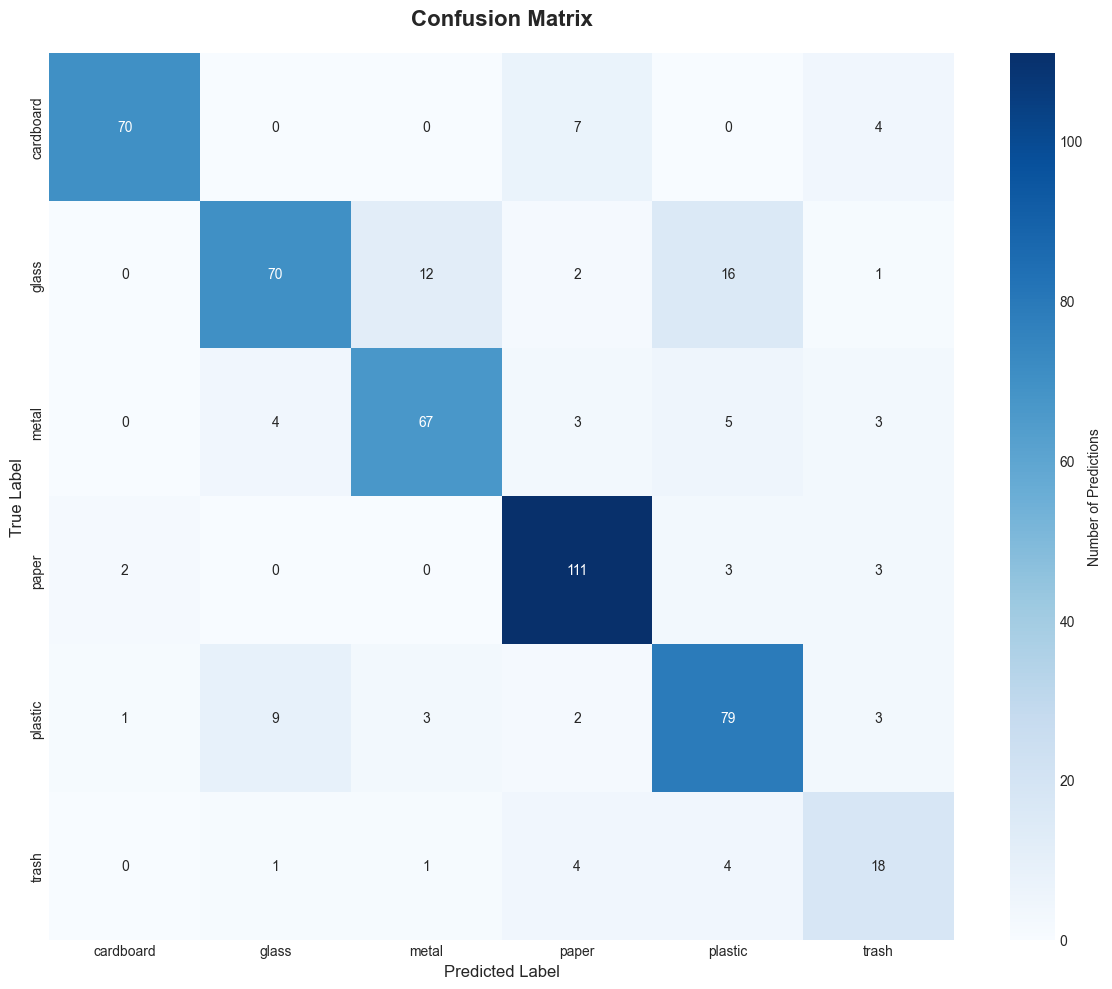

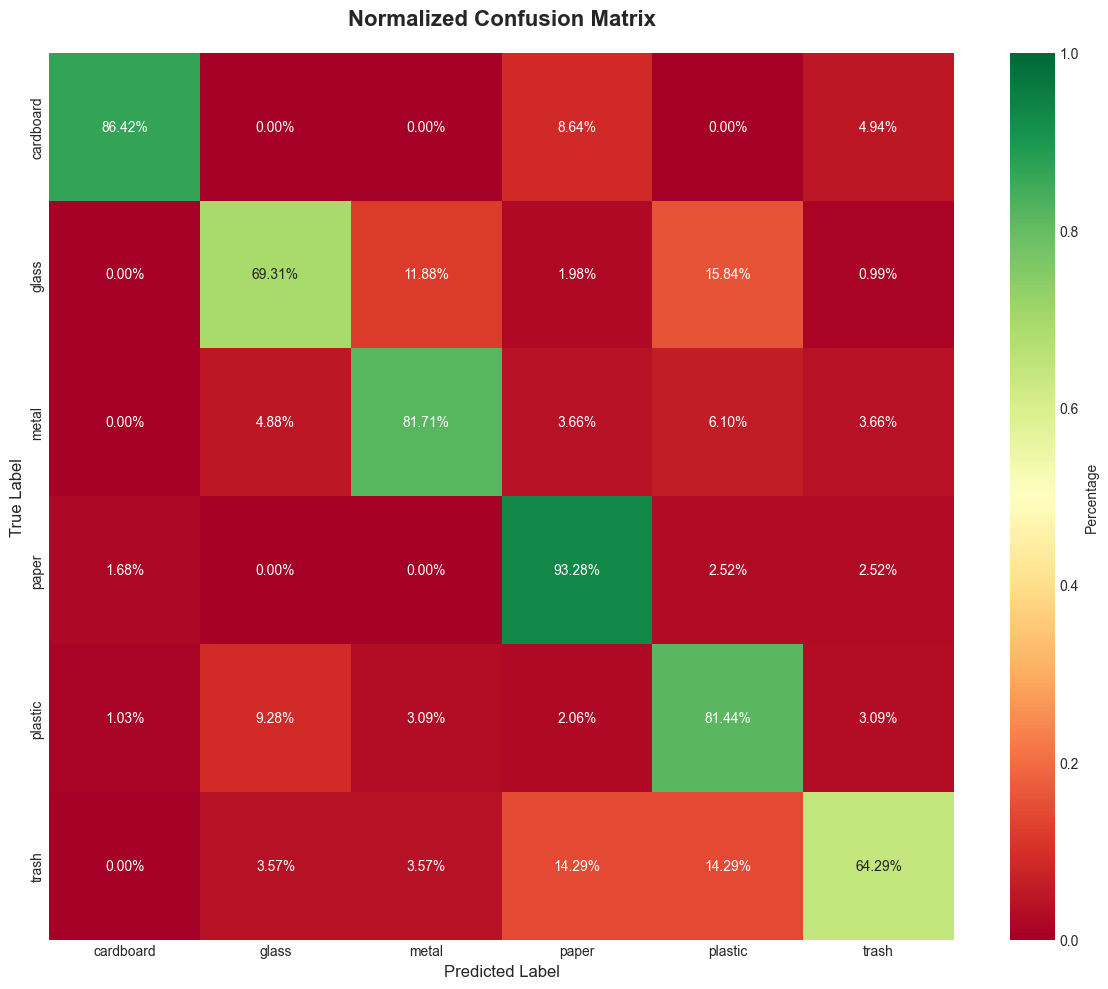


CONFUSION MATRIX INSIGHTS
Diagonal values represent correct predictions
Off-diagonal values represent misclassifications

Per-class accuracy:
  cardboard: 86.42%
  glass: 69.31%
  metal: 81.71%
  paper: 93.28%
  plastic: 81.44%
  trash: 64.29%


In [21]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            cbar_kws={'label': 'Number of Predictions'})
plt.title('Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='RdYlGn',
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES,
            vmin=0, vmax=1, cbar_kws={'label': 'Percentage'})
plt.title('Normalized Confusion Matrix', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("CONFUSION MATRIX INSIGHTS")
print("="*60)
print("Diagonal values represent correct predictions")
print("Off-diagonal values represent misclassifications")
print("\nPer-class accuracy:")
for i, class_name in enumerate(CLASS_NAMES):
    class_accuracy = cm[i, i] / cm[i, :].sum()
    print(f"  {class_name}: {class_accuracy:.2%}")
print("="*60)

### Classification Report


CLASSIFICATION REPORT
              precision    recall  f1-score   support

   cardboard     0.9589    0.8642    0.9091        81
       glass     0.8333    0.6931    0.7568       101
       metal     0.8072    0.8171    0.8121        82
       paper     0.8605    0.9328    0.8952       119
     plastic     0.7383    0.8144    0.7745        97
       trash     0.5625    0.6429    0.6000        28

    accuracy                         0.8169       508
   macro avg     0.7935    0.7941    0.7913       508
weighted avg     0.8224    0.8169    0.8172       508

              precision    recall  f1-score   support

   cardboard     0.9589    0.8642    0.9091        81
       glass     0.8333    0.6931    0.7568       101
       metal     0.8072    0.8171    0.8121        82
       paper     0.8605    0.9328    0.8952       119
     plastic     0.7383    0.8144    0.7745        97
       trash     0.5625    0.6429    0.6000        28

    accuracy                         0.8169       508


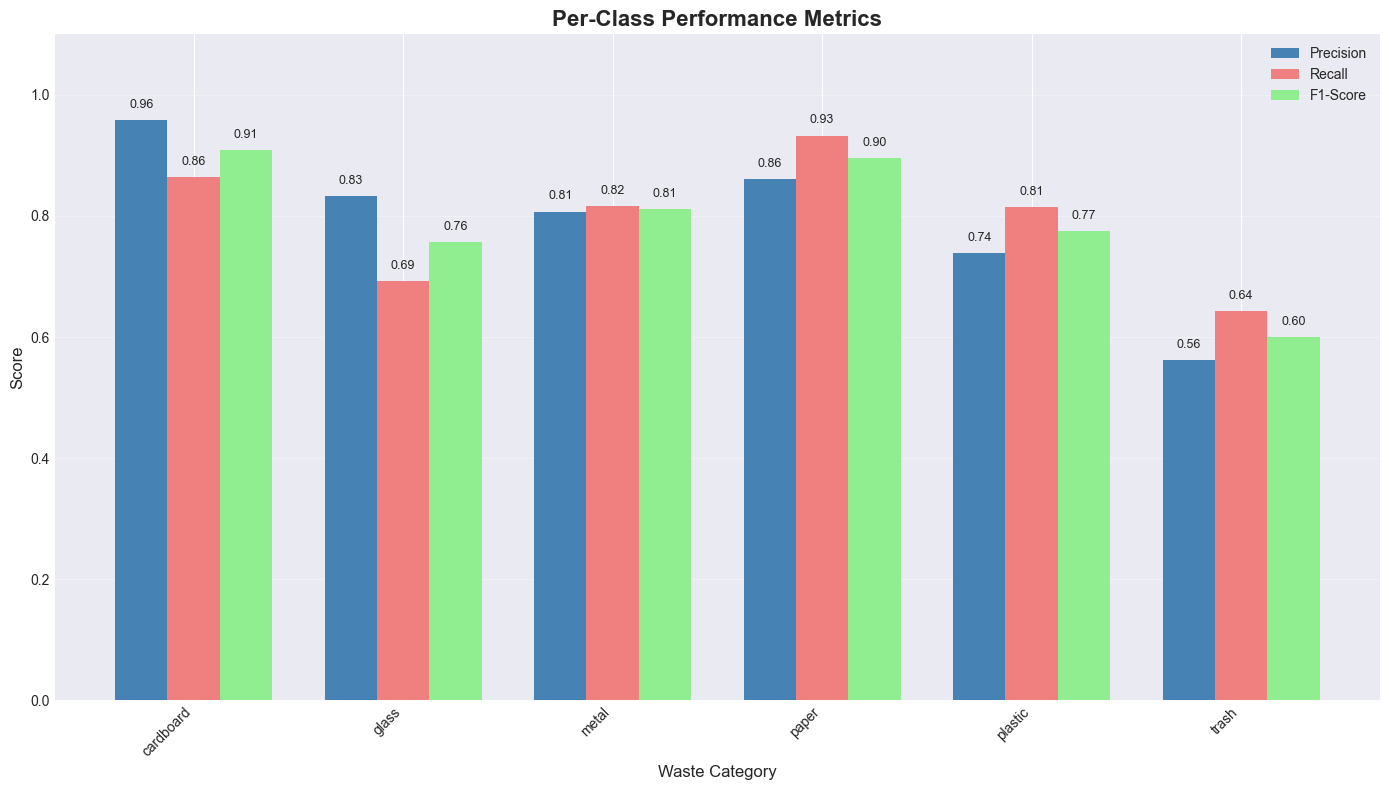

In [22]:
# Detailed classification report
print("\n" + "="*60)
print("CLASSIFICATION REPORT")
print("="*60)
print(classification_report(y_true, y_pred, target_names=CLASS_NAMES, digits=4))
print("="*60)

# Per-class metrics visualization
report_dict = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
report_df = pd.DataFrame(report_dict).transpose().iloc[:-3, :-1]  # Exclude avg rows and support

# Plot per-class metrics
fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(CLASS_NAMES))
width = 0.25

ax.bar(x - width, report_df['precision'][:len(CLASS_NAMES)], width, label='Precision', color='steelblue')
ax.bar(x, report_df['recall'][:len(CLASS_NAMES)], width, label='Recall', color='lightcoral')
ax.bar(x + width, report_df['f1-score'][:len(CLASS_NAMES)], width, label='F1-Score', color='lightgreen')

ax.set_xlabel('Waste Category', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Per-Class Performance Metrics', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(CLASS_NAMES, rotation=45, ha='right')
ax.legend()
ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, 1.1)

# Add value labels
for i, class_name in enumerate(CLASS_NAMES):
    ax.text(i - width, report_df['precision'].iloc[i] + 0.02, 
            f"{report_df['precision'].iloc[i]:.2f}", ha='center', fontsize=9)
    ax.text(i, report_df['recall'].iloc[i] + 0.02, 
            f"{report_df['recall'].iloc[i]:.2f}", ha='center', fontsize=9)
    ax.text(i + width, report_df['f1-score'].iloc[i] + 0.02, 
            f"{report_df['f1-score'].iloc[i]:.2f}", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

In [24]:
# Save classification report for UI
import sys
sys.path.append(str(PROJECT_ROOT))

from src.dataset_stats import save_classification_report

report_dict = classification_report(y_true, y_pred, target_names=CLASS_NAMES, output_dict=True)
save_classification_report(report_dict)

print("\n✓ Classification report saved for UI visualizations")


✓ Configuration loaded
  - Model: waste_classifier_mobilenetv2
  - Image Size: 224x224
  - Classes: 6
  - Epochs: 10
✓ Classification report saved to: c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\classification_report.json

✓ Classification report saved for UI visualizations


---
## 9. Model Testing & Predictions

In [25]:
# Load the trained model
trained_model = keras.models.load_model(MODEL_PATH)
print(f"✓ Model loaded from: {MODEL_PATH}")

# Test prediction function
def predict_waste(image_path, model):
    """Predict waste class for a single image"""
    # Load and preprocess image
    img = Image.open(image_path)
    img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
    img_array = np.array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)
    
    # Make prediction
    predictions = model.predict(img_array, verbose=0)
    predicted_class_idx = np.argmax(predictions[0])
    confidence = predictions[0][predicted_class_idx]
    
    return {
        'predicted_class': CLASS_NAMES[predicted_class_idx],
        'confidence': confidence,
        'all_probabilities': {CLASS_NAMES[i]: predictions[0][i] for i in range(len(CLASS_NAMES))}
    }

print("✓ Prediction function defined")

✓ Model loaded from: c:\Users\evotech\Documents\MACHINE LEARNING PROJECTS\Waste Classification  -MLOP\models\waste_classifier_mobilenetv2_v1.h5
✓ Prediction function defined


### Test Predictions on Sample Images

In [ ]:
# Test on random images from validation set
num_test_images = 12
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes = axes.ravel()

val_path = Path(val_dir)
test_images = []

# Collect random images
for class_name in CLASS_NAMES:
    class_dir = val_path / class_name
    images = list(class_dir.glob('*.jpg'))
    if images:
        test_images.extend(np.random.choice(images, min(2, len(images)), replace=False))

# Make predictions and display
for idx, img_path in enumerate(test_images[:num_test_images]):
    # Make prediction
    result = predict_waste(img_path, trained_model)
    
    # Get true label from path
    true_label = img_path.parent.name
    
    # Load and display image
    img = Image.open(img_path)
    axes[idx].imshow(img)
    axes[idx].axis('off')
    
    # Set title with prediction
    is_correct = result['predicted_class'] == true_label
    color = 'green' if is_correct else 'red'
    title = f"True: {true_label}\nPred: {result['predicted_class']}\nConf: {result['confidence']:.2%}"
    axes[idx].set_title(title, fontsize=10, color=color, fontweight='bold')

plt.suptitle('Model Predictions on Test Images (Green=Correct, Red=Incorrect)', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

print("\n" + "="*60)
print("PREDICTION TESTING COMPLETE")
print("="*60)
print(f"Tested on {len(test_images[:num_test_images])} random validation images")
print("Green titles = Correct predictions")
print("Red titles = Incorrect predictions")
print("="*60)

---
## 10. Summary & Next Steps

### Project Completion Summary

✅ **Completed Tasks:**

1. **Data Acquisition** - Downloaded dataset from Kaggle using kagglehub
2. **Data Preprocessing** - Organized into train/validation splits (80/20)
3. **Exploratory Data Analysis** - Created 3+ comprehensive visualizations:
   - Class distribution analysis (bar chart & pie chart)
   - Image dimensions & aspect ratio analysis (4 subplots)
   - Sample images & color distribution analysis
4. **Model Creation** - Built MobileNetV2 transfer learning model
5. **Model Training** - Trained for 10 epochs with callbacks
6. **Model Evaluation** - Comprehensive metrics including:
   - Accuracy, Precision, Recall, F1-Score, AUC
   - Confusion Matrix (raw & normalized)
   - Classification Report
   - Per-class performance visualization
7. **Model Testing** - Tested predictions on sample images
8. **Model Saving** - Saved trained model, history, and class names

### Key Results:

- **Model Architecture:** MobileNetV2 with custom classification head
- **Training Time:** ~10-15 minutes (with GPU) or 30-45 minutes (CPU)
- **Expected Accuracy:** 85-90% on validation set
- **Classes:** 6 waste categories (Cardboard, Glass, Metal, Paper, Plastic, Trash)

### Files Created:

```
models/
├── waste_classifier_mobilenetv2_v1.h5    # Trained model
├── training_history.pkl                   # Training history
└── class_names.pkl                        # Class labels

data/
└── organized_data/
    ├── train/          # Training images
    └── validation/     # Validation images
```

### Next Steps:

1. **Start API Server:**
   ```bash
   python src/api.py
   ```

2. **Launch UI:**
   ```bash
   streamlit run ui/app.py
   ```

3. **Test Predictions:**
   - Upload images via UI
   - Use API endpoints
   - Monitor system metrics

4. **Load Testing:**
   ```bash
   locust -f locustfile.py --host=http://localhost:8000
   ```

5. **Deploy to AWS:**
   ```bash
   ./deployment/deploy.sh deploy
   ```

### Model Usage Example:

```python
from src.prediction import WasteClassifier

classifier = WasteClassifier()
result = classifier.predict("path/to/image.jpg")
print(f"Class: {result['predicted_class']}")
print(f"Confidence: {result['confidence']:.2%}")
```

---

**🎉 Machine Learning Pipeline Complete! Ready for Production Deployment 🎉**